In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
       # return 'r' if open_price[index] > close_price[index] else 'g'
        if abs(open_price[index]-close_price[index])<=0.5*(high[index]-low[index]):
            return 'b'
        elif open_price[index] - close_price[index] > 0 :
            return 'r'
        elif open_price[index] - close_price[index] <= 0:
            return 'g'
        else: 
            print('Return')
    
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['Open']
    close_price = pricing['Close']
    low = pricing['Low']
    high = pricing['High']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%Y-%m-%d'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['Volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)

In [87]:
import os

In [88]:
hdfc = pd.read_csv('hdfc.csv')

In [89]:
hdfc['Date'] = hdfc['Date'].apply(pd.to_datetime)
hdfc.set_index('Date',inplace=True)

In [90]:
hdfc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-03,2004.000000,2032.449951,1997.150024,2013.099976,1982.898438,4345772.0
2019-04-04,2008.000000,2058.800049,2006.300049,2042.050049,2011.414185,4463212.0
2019-04-05,2045.000000,2065.000000,2035.000000,2059.199951,2028.306885,2576789.0
2019-04-08,2068.000000,2072.500000,2029.250000,2054.899902,2024.071411,2057768.0
2019-04-09,2062.500000,2073.000000,2039.150024,2069.149902,2038.107544,2381281.0
...,...,...,...,...,...,...
2020-03-26,1689.500000,1843.449951,1671.199951,1733.250000,1733.250000,12104338.0
2020-03-27,1785.199951,1849.650024,1710.050049,1754.000000,1754.000000,9048364.0
2020-03-30,1667.300049,1699.000000,1548.000000,1558.750000,1558.750000,8670676.0


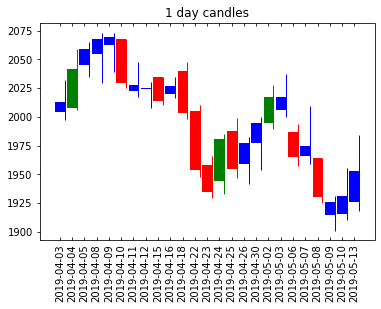

In [93]:
plot_candles(hdfc[:25], title='1 day candles')